In [2]:
import rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_img = [im for im in images['s2_cloudy'].iterdir()][-3]
rio_cloudy = rio.open(path_img)
path_img = [im for im in images['s2'].iterdir()][0]
rio_cloudless = rio.open(path_img)

def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    # np.exp(-2, -3, -4) determines the bluriness
    return 255 / (1 + np.exp(-4 * (scaled(x) / 255 - 0.5)))

def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

cloudy = get_tci(rio_cloudy)
cloudless = get_tci(rio_cloudless)

In [4]:
def get_bands(img, correction):
    bands = [correction(img.read(b)) for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0)
b_cloudy = get_bands(rio_cloudy, lambda x: x)

In [5]:
def get_variance(band):
    laplacian = cv2.Laplacian(band, cv2.CV_64F)
    variance = laplacian.var()
    return variance

def get_blur_scores(img):
    return [get_variance(img[:,:,i]) for i in range(img.shape[-1])]        

get_blur_scores(b_cloudy)

[958.5264071540441,
 8474.436206786893,
 11282.707234458765,
 18321.303334148368,
 18224.588258362375,
 57300.67125297687,
 83602.41695127543,
 130596.73160729464,
 115462.86278843507,
 2405.834482154809,
 284.19680202542804,
 37358.22162054479,
 16268.892921209335]

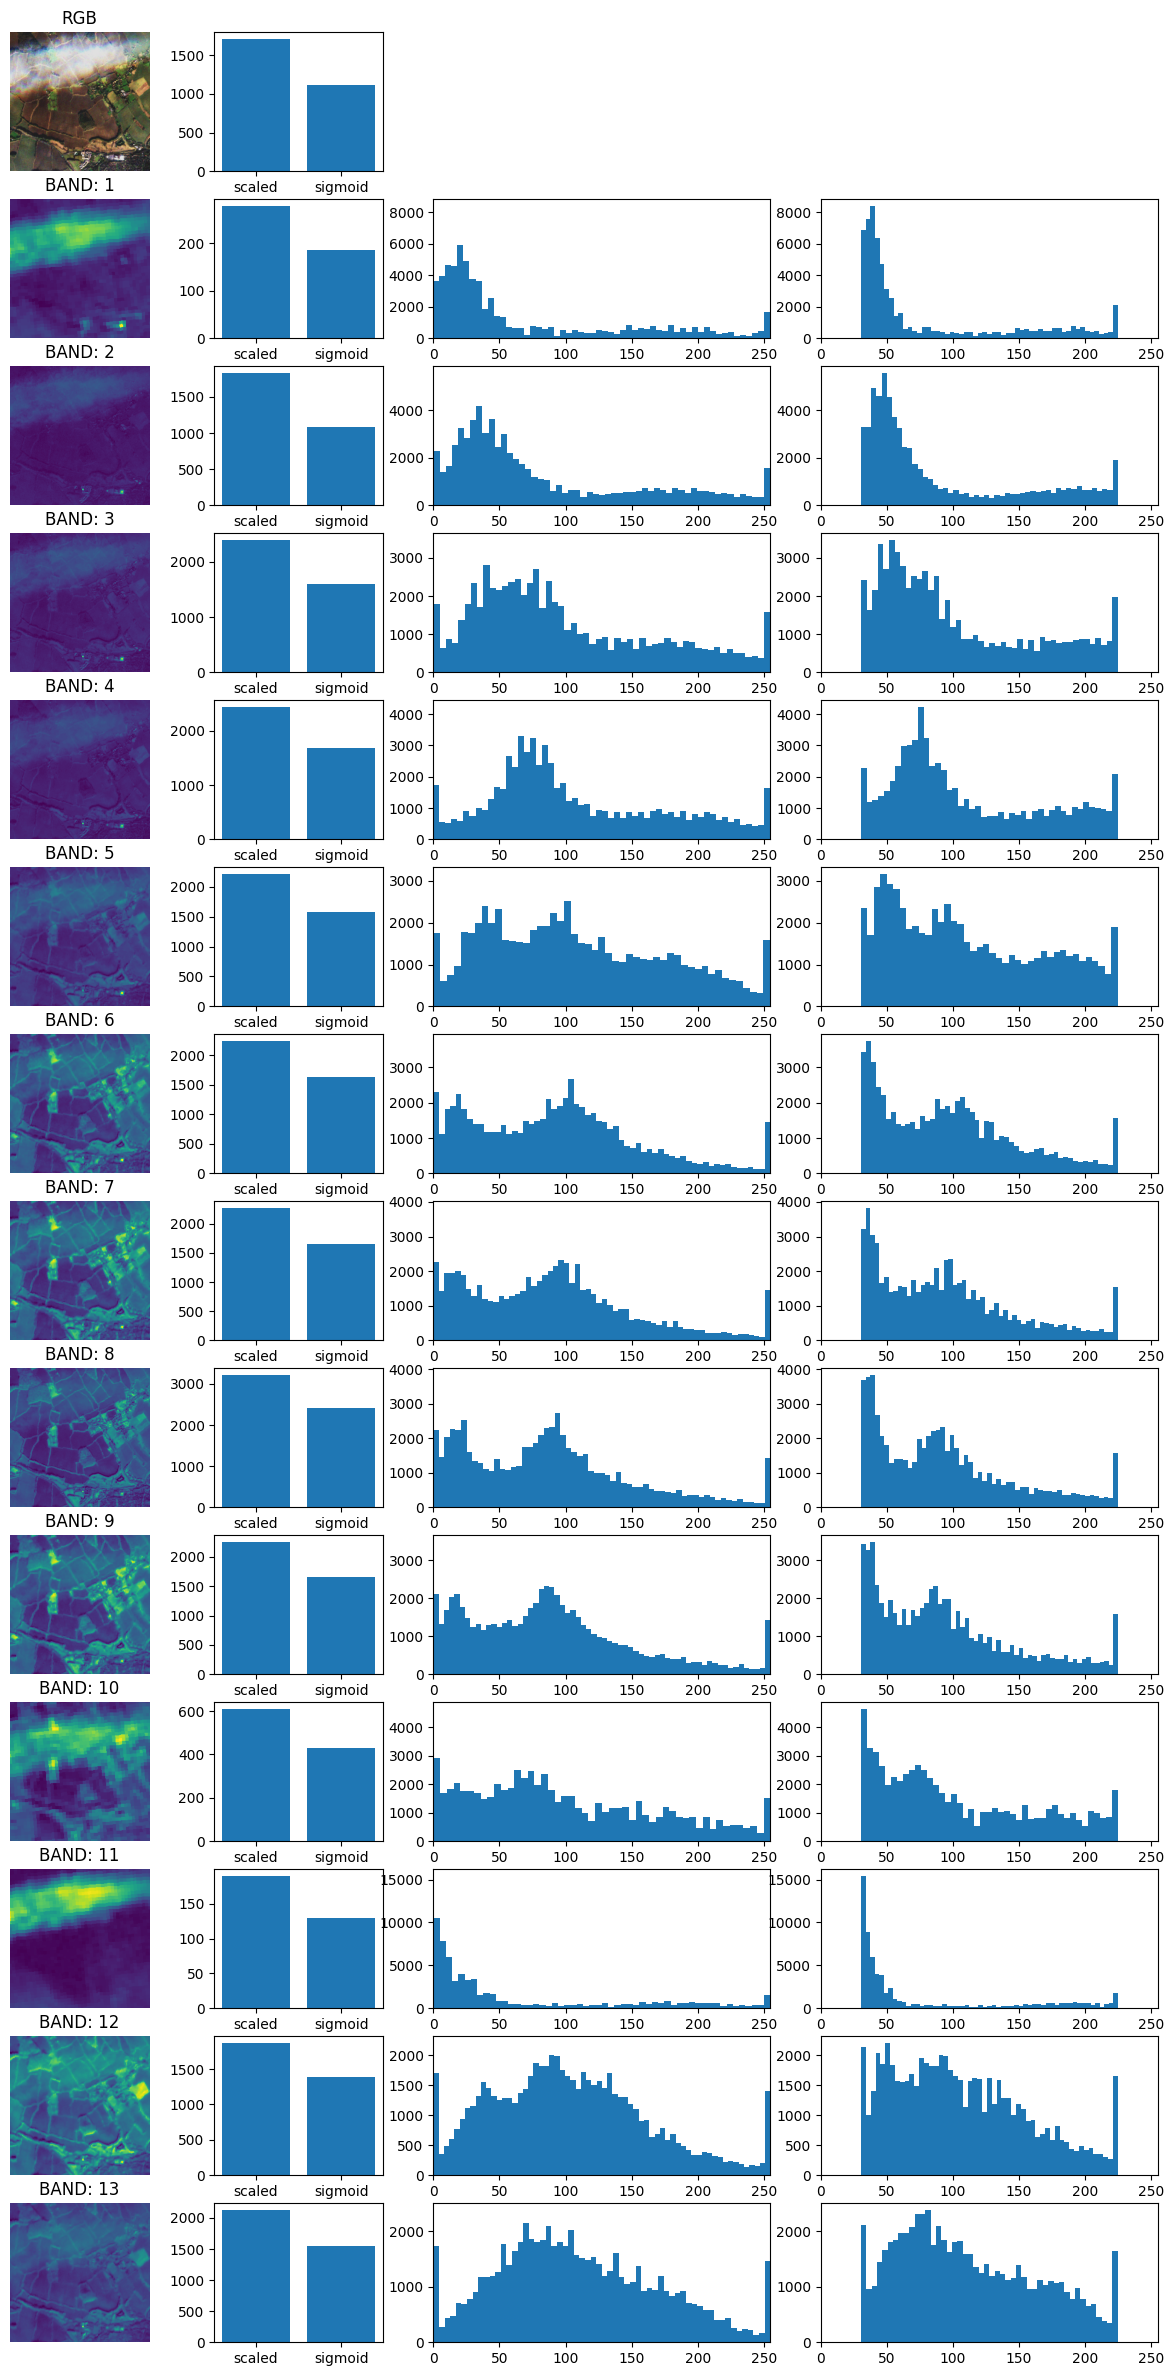

In [6]:
def plot_imshow(ax_row, band):
    ax_row[0].axis('off')
    ax_row[0].imshow(band)

def plot_blur_bar(ax_row, i, rio_img):
    ax_row[1].bar(['scaled', 'sigmoid'], [get_variance(get_bands(rio_img, lambda x : scaled(x / 1000 * 255))[:, :, i]),get_variance(get_bands(rio_img, lambda x : sigmoid(x / 1000 * 255))[:, :, i])])

def plot_line(ax_row, i, rio_img):
    img = get_bands(rio_img, lambda x:x)
    band = img[:,:,i]
    plot_imshow(ax_row, band)

def get_scaled_tci_img(img):
    r = scaled(img.read(4))
    g = scaled(img.read(3))
    b = scaled(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def plot_blur(rio_img):
    fig, axs = plt.subplots(14, 4, figsize=(15, 30), gridspec_kw={"width_ratios": (1,1, 2, 2)})
    rgb = get_tci(rio_img)
    plot_imshow(axs[0], rgb)
    gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    rgb = get_scaled_tci_img(rio_img)
    gray2 = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    axs[0][1].bar(['scaled', 'sigmoid'], [get_variance(gray2), get_variance(gray)])
    axs[0][0].set_title("RGB")
    axs[0][2].axis('off')
    axs[0][3].axis('off')
    for i, ax_row in enumerate(axs[1:]):
        plot_line(ax_row, i, rio_img)
        plot_blur_bar(ax_row, i, rio_img)
        ax_row[0].set_title("BAND: " + str(i+1))
        img = get_bands(rio_img, scaled)
        _ = ax_row[2].hist(img[:,:,i].reshape(-1), bins='auto')
        ax_row[2].set_xlim([0, 255])
        img = get_bands(rio_img, sigmoid)
        _ = ax_row[3].hist(img[:,:,i].reshape(-1), bins='auto')
        ax_row[3].set_xlim([0, 255])
        ax_row[2].sharey(ax_row[3])
plot_blur(rio_cloudy)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_30360\2559137460.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1].get_shared_y_axes().join(ax[1], ax[3])


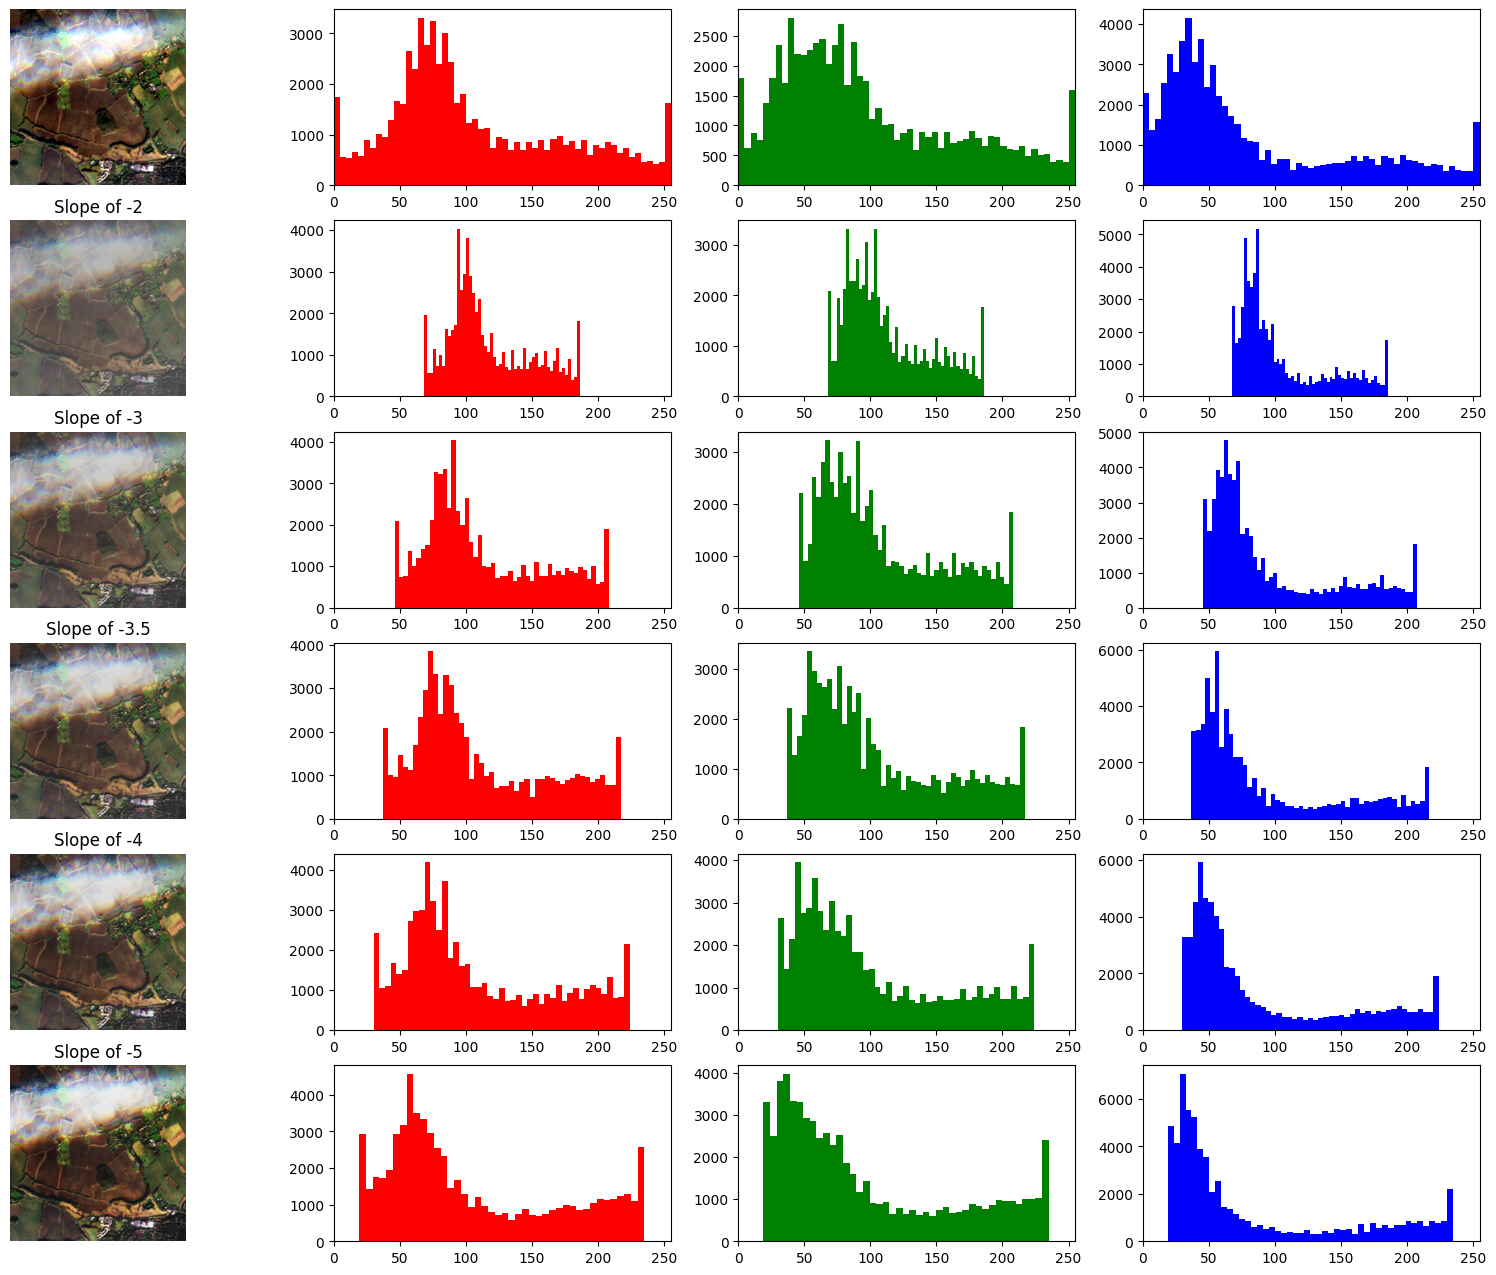

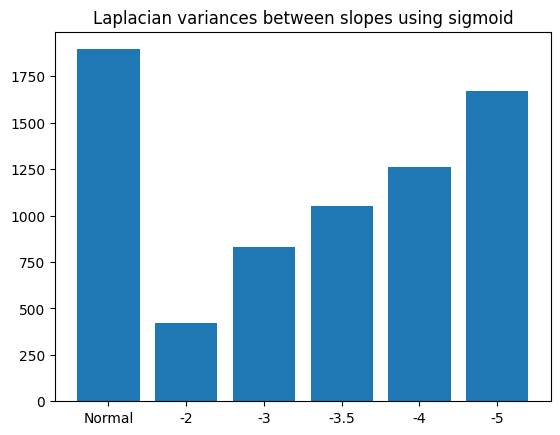

In [7]:
# plot different sigmoids to understand the proceess
from collections import defaultdict

def sigmoid_exp(x, slope, midpoint=0.5):
    return 255 / (1 + np.exp(slope * (scaled(x) / 255 - 0.5)))

def get_tci_sigmoid(rio_img, slope):
    rgb = [sigmoid_exp(rio_img.read(b), slope) for b in [4,3,2]]
    rgb = np.stack(rgb)
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def plot_histogram(ax, img):
    _ = ax[1].hist(img[:, :, 0].reshape(256 * 256), bins='auto', color="r")
    ax[1].set_xlim([0, 255])
    _ = ax[2].hist(img[:, :, 1].reshape(256 * 256), bins='auto', color="g")
    ax[2].set_xlim([0, 255])
    _ = ax[3].hist(img[:, :, 2].reshape(256 * 256), bins='auto', color="b")
    ax[3].set_xlim([0, 255])
    ax[1].get_shared_y_axes().join(ax[1], ax[3])

def show_differences_between_slopes(rio_cloudy):
    slopes = [-2, -3, -3.5, -4, -5]
    fig, axs = plt.subplots(len(slopes) + 1, 4, figsize=(20, 16))
    variances = defaultdict(list)
    img = get_bands(rio_cloudy, scaled)[:, :, [3,2,1]]
    axs[0][0].imshow(img)
    axs[0][0].axis('off')
    plot_histogram(axs[0], img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    variances['variance'].append(get_variance(gray))
    variances['type'].append('Normal')
    for ax, slope in zip(axs[1:], slopes):
        img = get_tci_sigmoid(rio_cloudy, slope)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        variances['variance'].append(get_variance(gray))
        variances['type'].append(f"{slope}")
        ax[0].imshow(img)
        ax[0].axis('off')
        ax[0].set_title("Slope of {}".format(slope))
        plot_histogram(ax, img)
    plt.show()
    ax = plt.subplot(111)
    ax.bar(variances['type'], variances['variance'])
    ax.set_title("Laplacian variances between slopes using sigmoid")
show_differences_between_slopes(rio_cloudy)

In [47]:
from skimage import data, img_as_float
from skimage import exposure
import seaborn as sns

In [48]:

img = get_tci_sigmoid(rio_cloudy, -4)
gamma_corrected = exposure.adjust_gamma(img, 2)
logarithmic_corrected = exposure.adjust_log(img, 1)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_14380\925346541.py:9: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1].get_shared_y_axes().join(ax[2], ax[3])


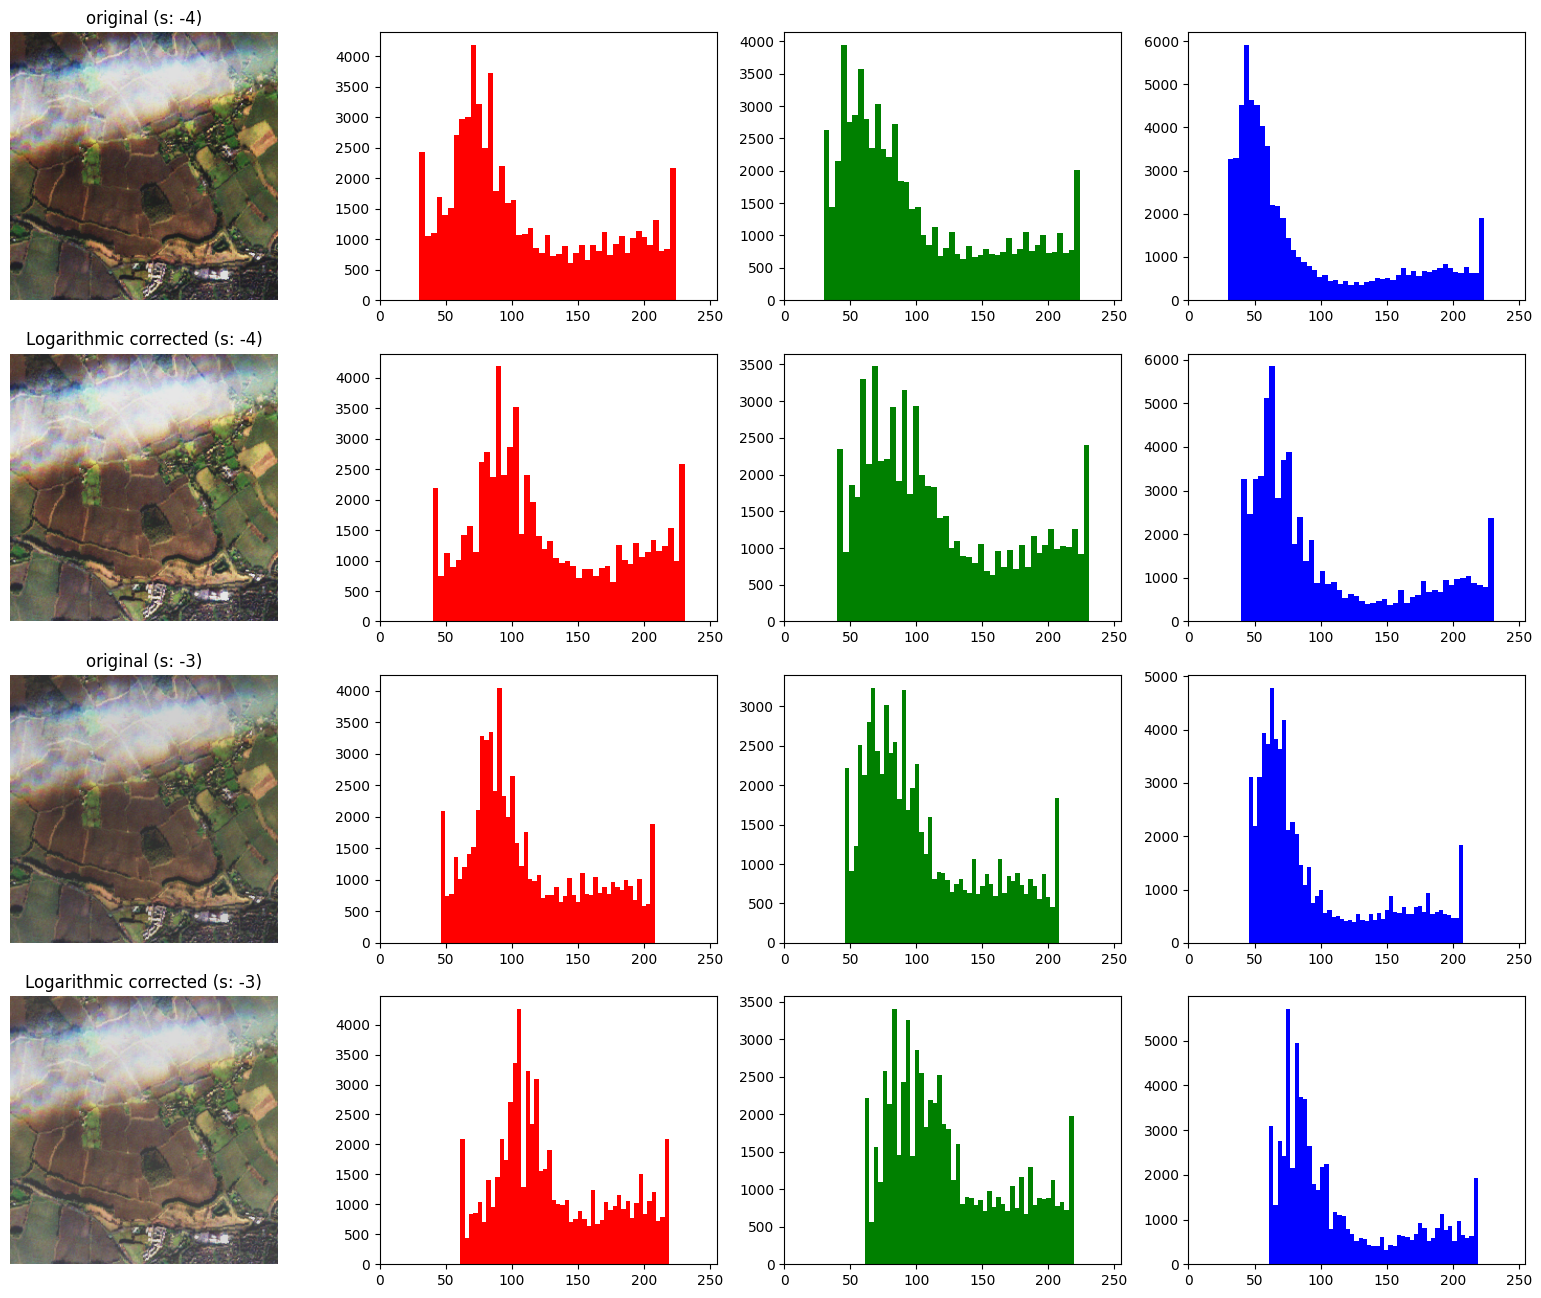

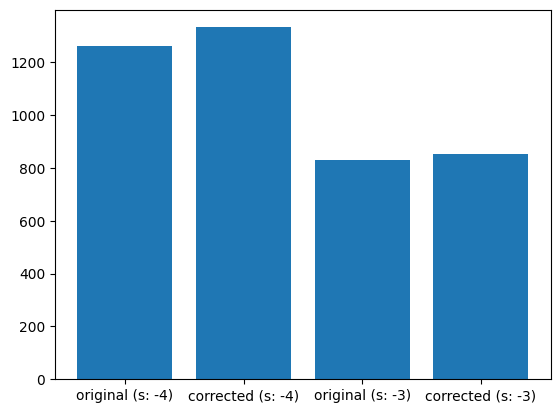

In [49]:
def plot_histogram(ax, img):
    _ = ax[1].hist(img[:, :, 0].reshape(256 * 256), bins='auto', color="r")
    #sns.kdeplot(data=img[:, :, 0].ravel(), ax=ax[1])
    ax[1].set_xlim([0, 255])
    _ = ax[2].hist(img[:, :, 1].reshape(256 * 256), bins='auto', color="g")
    ax[2].set_xlim([0, 255])
    _ = ax[3].hist(img[:, :, 2].reshape(256 * 256), bins='auto', color="b")
    ax[3].set_xlim([0, 255])
    ax[1].get_shared_y_axes().join(ax[2], ax[3])

def plot_img(img, title, ax):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

def compute_rgb_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    return get_variance(gray)

def plot_logarithmic(rio):
    fig, axs = plt.subplots(4, 4, figsize=(20, 4 * 4), gridspec_kw={"width_ratios": (1, 1,1,1)})
    scores = dict()
    img = get_tci(rio)
    logarithmic_corrected = exposure.adjust_log(img, 1)

    plot_histogram(axs[0], img)
    plot_img(img, "original (s: -4)", axs[0][0])
    plot_histogram(axs[1], logarithmic_corrected)
    scores['original (s: -4)'] = (compute_rgb_contrast(img))
    scores['corrected (s: -4)'] = (compute_rgb_contrast(logarithmic_corrected))
    plot_img(logarithmic_corrected, "Logarithmic corrected (s: -4)", axs[1][0])
    img_new_slope = get_tci_sigmoid(rio, -3)
    logarithmic_corrected2 = exposure.adjust_log(img_new_slope, 1)
    scores['original (s: -3)'] = (compute_rgb_contrast(img_new_slope))
    plot_histogram(axs[2], img_new_slope)
    plot_img(img_new_slope, "original (s: -3)", axs[2][0])

    plot_histogram(axs[3], logarithmic_corrected2)
    plot_img(logarithmic_corrected2, "Logarithmic corrected (s: -3)", axs[3][0])
    scores['corrected (s: -3)'] = (compute_rgb_contrast(logarithmic_corrected2))
    plt.show()
    plt.bar(scores.keys(), scores.values())
    plt.show()
plot_logarithmic(rio_cloudy)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_14380\925346541.py:9: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1].get_shared_y_axes().join(ax[2], ax[3])


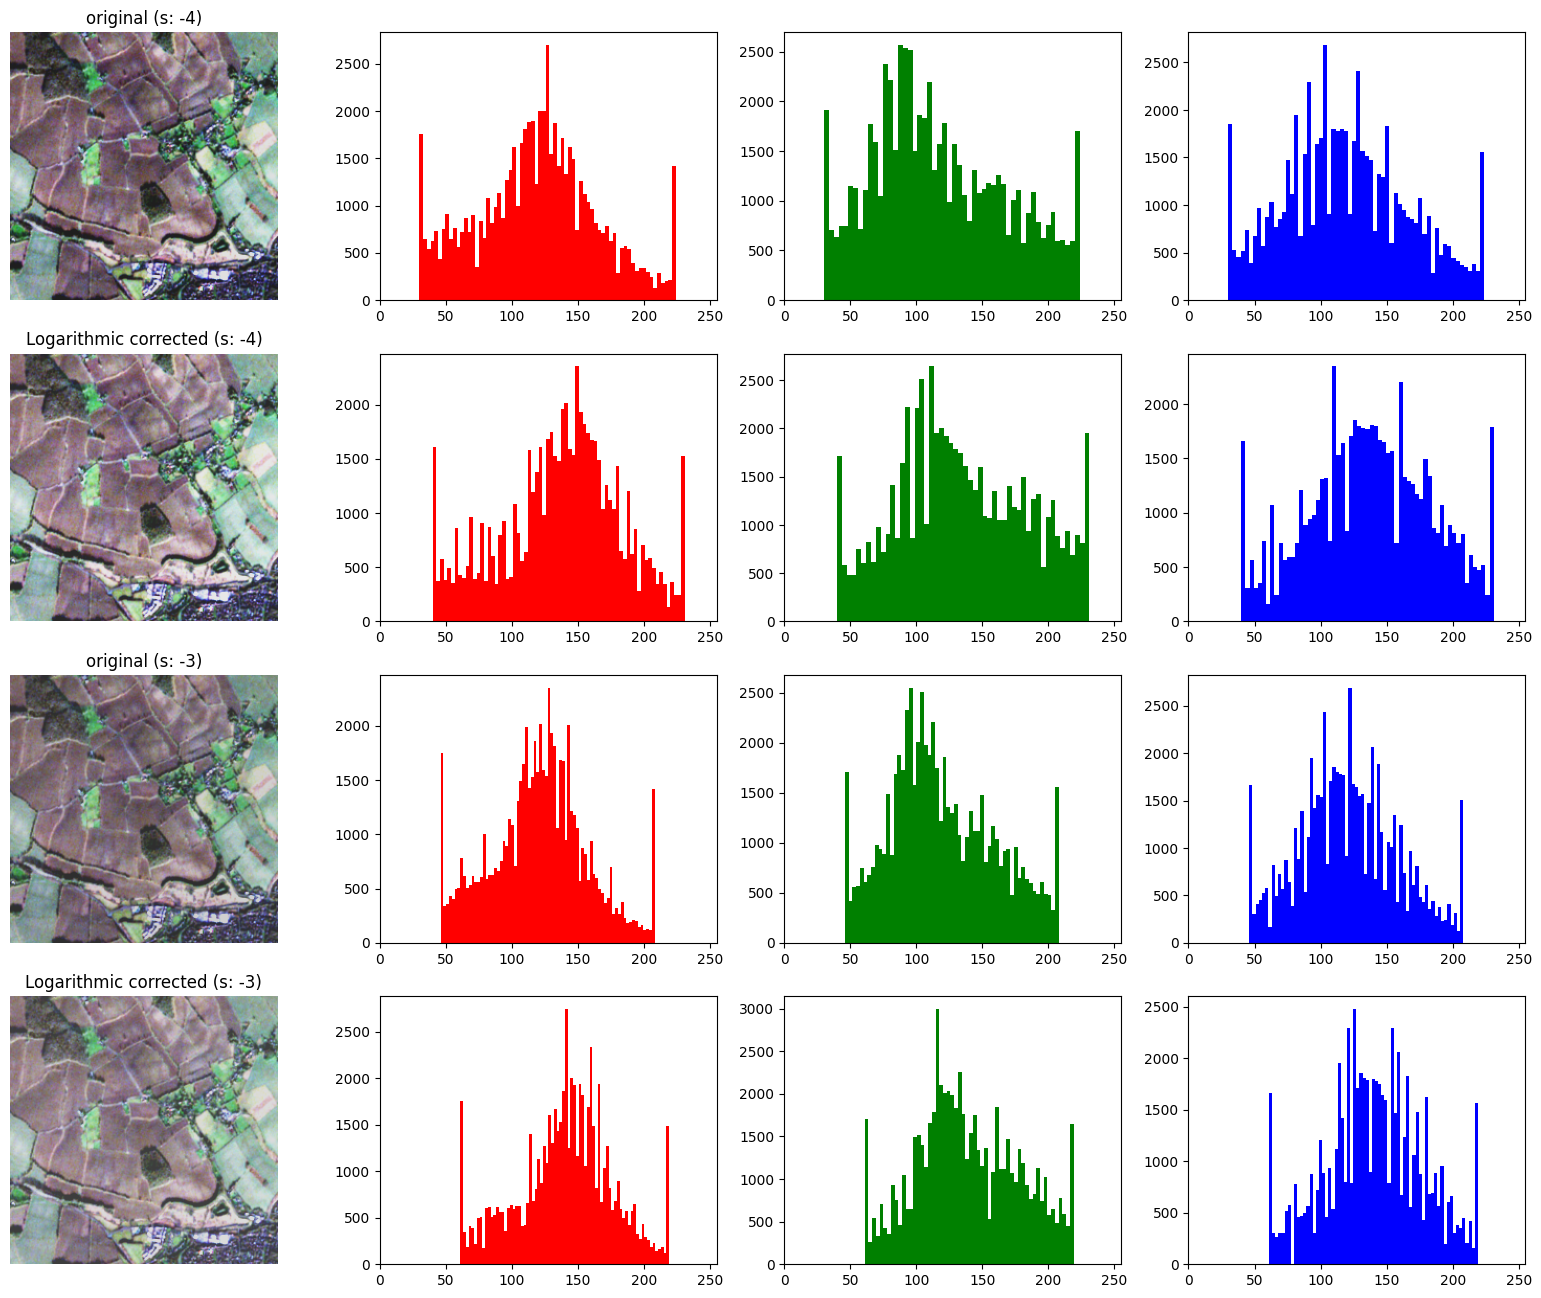

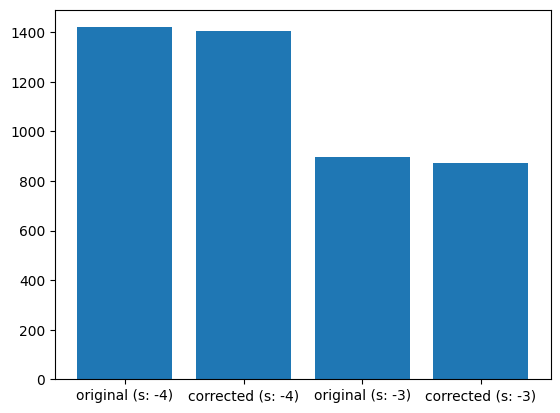

In [50]:
plot_logarithmic(rio_cloudless)